In [1]:
import os
cwd = os.getcwd()
print(cwd)
if cwd[-9:] == 'NoteBooks' or cwd[-5:] in ['/ilc2', '/data']:
    try:
        # Move up to root folder
        os.chdir(".." + ('/..' if cwd[-5:] == '/ilc2' else ''))
        print(f"Directory changed: {os.getcwd()}")
    except OSError:
        print("Can't change the Current Working Directory") 
else:
    print("No need to change the Current Working Directory")

/Users/romainfouilland/code/cours/P3A/data/ilc2
Directory changed: /Users/romainfouilland/code/cours/P3A


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from glob import glob

In [4]:
import json
import os
from pathlib import Path

import pandas as pd
import numpy as np

from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

floor_data_dir = './data/ilc2/data/site1/F1'
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = './data/ilc2/output/site1/F1'
path_image_save_dir = save_dir + '/path_images'
step_position_image_save_dir = save_dir
magn_image_save_dir = save_dir
wifi_image_save_dir = save_dir + '/wifi_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'
wifi_count_image_save_dir = save_dir

In [5]:
Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# Investigating a trace file

In [6]:
from tqdm.auto import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from integrations.ilc2 import get_input, json_points_to_array, collect_stats, get_filenames, collect_paths, visualize, load_stats, write_stats

In [7]:
path_filenames = get_filenames(path_data_dir)[:10]
path_filenames

[PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd5ec5b77e0006b173da.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd649191710006b570f4.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd4ec5b77e0006b173ce.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd47c5b77e0006b173c8.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd669191710006b570f6.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9ef8dc5b77e0006b17359.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd60c5b77e0006b173dc.txt'),
 PosixPath('/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd67c5b77e0006b173e4.txt'),
 PosixPath('/Users/romai

In [8]:
json_paths = collect_paths(path_filenames)
json_paths

  0%|          | 0/10 [00:00<?, ?it/s]

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.


[{'file': '/Users/romainfouilland/code/cours/P3A/data/ilc2/data/site1/F1/path_data_files/5dd9fd5ec5b77e0006b173da.txt',
  't0': 0,
  'tf': -1574566385021.0,
  'points': [{'r_id': 1,
    'x': 196.26472,
    'y': 114.8901,
    't': 0,
    't_id': 0,
    'r_type': 'bluetooth',
    '_data': {'t': 0.0}},
   {'r_id': 2,
    'x': 196.94728,
    'y': 117.62149,
    't': 3755,
    't_id': 0,
    'r_type': 'bluetooth',
    '_data': {'t': 3755.0}},
   {'r_id': 3,
    'x': 208.12675,
    'y': 116.20255,
    't': 16911,
    't_id': 0,
    'r_type': 'bluetooth',
    '_data': {'t': 16911.0}},
   {'r_id': 4,
    'x': 206.11342,
    'y': 113.105,
    't': 22261,
    't_id': 0,
    'r_type': 'bluetooth',
    '_data': {'t': 22261.0}},
   {'r_id': 5,
    'x': 199.0444,
    'y': 109.97728,
    't': 31329,
    't_id': 0,
    'r_type': 'bluetooth',
    '_data': {'t': 31329.0},
    'md': {'exit': 1}}],
  '_data': {'t0': 1574566416350.0, 'tf': 31329}},
 {'file': '/Users/romainfouilland/code/cours/P3A/data/ilc2

In [9]:
# Computing stats
stats = collect_stats(json_paths)
stats

  0%|          | 0/10 [00:00<?, ?it/s]

,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
0,/Users/romainfouilland/code/cours/P3A/data/ilc...,5,0.463237,7832.250000,0.089398,site1,F1,5dd9fd5ec5b77e0006b173da
1,/Users/romainfouilland/code/cours/P3A/data/ilc...,3,0.470829,12718.000000,0.150494,site1,F1,5dd9fd649191710006b570f4
2,/Users/romainfouilland/code/cours/P3A/data/ilc...,12,0.441736,4194.818182,0.252844,site1,F1,5dd9fd4ec5b77e0006b173ce
3,/Users/romainfouilland/code/cours/P3A/data/ilc...,3,0.431057,8046.500000,0.008296,site1,F1,5dd9fd47c5b77e0006b173c8
4,/Users/romainfouilland/code/cours/P3A/data/ilc...,5,0.283175,7731.750000,0.432103,site1,F1,5dd9fd669191710006b570f6
5,/Users/romainfouilland/code/cours/P3A/data/ilc...,20,0.530575,5506.526316,0.358767,site1,F1,5dd9ef8dc5b77e0006b17359
6,/Users/romainfouilland/code/cours/P3A/data/ilc...,4,0.427371,7645.333333,0.083973,site1,F1,5dd9fd60c5b77e0006b173dc
7,/Users/romainfouilland/code/cours/P3A/data/ilc...,6,0.294774,6833.000000,0.326024,site1,F1,5dd9fd67c5b77e0006b173e4
8,/Users/romainfouilland/code/cours/P3A/data/ilc...,11,0.341685,8113.400000,0.248465,site1,F1,5dd9fd3a9191710006b570d2
9,/Users/romainfouilland/code/cours/P3A/data/ilc...,7,0.343712,4957.500000,0.374727,site1,F1,5dd9efa69191710006b5708c


In [10]:
FULL = True
WRITE_STATS = False

data_folder = "./data/ilc2/data/"
traces_folder = '/path_data_files'

if FULL:
    data_folder = "/Volumes/DD Romain/dataP3a/indoor-location-navigation/train"
    traces_folder = ''

stats_path = data_folder + '/stats.csv'

In [11]:
# Get path_filenames
# If write_stats -> collect them all
# Else, load write_stats and do filtering
if WRITE_STATS:
    path_filenames = []
    for floor in tqdm(glob(data_folder + '/*/*/')):
        path_filenames.extend(get_filenames(floor + traces_folder))
else:
    stats_df = load_stats(stats_path)
    # Do filtering on stats_df
    path_filenames = list(map(Path, stats_df['filepath']))

path_filenames

  0%|          | 0/981 [00:00<?, ?it/s]

[PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730aa280850006f3d005.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730b1506f2000638fc29.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730ca280850006f3d007.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730e1506f2000638fc2b.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e15730f1506f2000638fc2d.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e157310a280850006f3d009.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a0546857ecc773753327266/B1/5e1573121506f2000638fc2f.txt'),
 PosixPath('/Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5a05

In [12]:
json_paths = collect_paths(path_filenames)

if WRITE_STATS:
    stats_dfs = []
    stats_dfs.append(collect_stats(json_paths))
    stats = pd.concat(stats_dfs)
    write_stats(stats, stats_path)

df = stats.sort_values(by='nb_points', ascending=False)
df.describe()

  0%|          | 0/26925 [00:00<?, ?it/s]

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path  -> skipped /Volumes/DD Romain/dataP3a/indoor-location-navigation/train/5cd56b83e2acfd2d33b5cab0/B2/5cf72539e9d9c9000852f45b.txt (list index out of range)
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> do

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading pa

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.


  0%|          | 0/26924 [00:00<?, ?it/s]

/Users/romainfouilland/code/envs/p3a/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/romainfouilland/code/envs/p3a/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/romainfouilland/code/envs/p3a/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/romainfouilland/code/envs/p3a/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/romainfouilland/code/envs/p3a/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rom

,nb_points,timestep_dev,timestep_avg,speed_dev
count,26924.000000,26918.000000,26918.000000,26916.000000
mean,6.190796,0.243667,10357.674513,0.170554
std,5.814631,0.187330,6921.145230,0.135066
min,1.000000,0.000000,1482.000000,0.000000
25%,3.000000,0.065402,6716.937500,0.045180
50%,4.000000,0.252296,9184.111111,0.167971
75%,7.000000,0.372937,12413.204054,0.263023
max,107.000000,1.795394,185382.000000,1.158141


In [13]:
df.describe()

,nb_points,timestep_dev,timestep_avg,speed_dev
count,26924.000000,26918.000000,26918.000000,26916.000000
mean,6.190796,0.243667,10357.674513,0.170554
std,5.814631,0.187330,6921.145230,0.135066
min,1.000000,0.000000,1482.000000,0.000000
25%,3.000000,0.065402,6716.937500,0.045180
50%,4.000000,0.252296,9184.111111,0.167971
75%,7.000000,0.372937,12413.204054,0.263023
max,107.000000,1.795394,185382.000000,1.158141


In [14]:
df.iloc[:50]

,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
22636,/Volumes/DD Romain/dataP3a/indoor-location-nav...,107,0.377507,9654.764151,0.342906,5da1383b4db8ce0c98bc11ab,F1,5dd3824044333f00067aa2c4
21260,/Volumes/DD Romain/dataP3a/indoor-location-nav...,83,0.677015,10207.926829,0.299230,5d2709e003f801723c32d896,B1,5dc8e91a17ffdd0006f12ce0
20605,/Volumes/DD Romain/dataP3a/indoor-location-nav...,82,0.746193,9935.111111,0.288359,5d2709d403f801723c32bd39,2F,5dce884b5516ad00065f03e3
12880,/Volumes/DD Romain/dataP3a/indoor-location-nav...,82,0.428013,13473.358025,0.281550,5cd969c839e2fc0b4afe7ff0,F4,5d08532629994a000820255e
19594,/Volumes/DD Romain/dataP3a/indoor-location-nav...,79,0.639127,12867.628205,0.468422,5d2709bb03f801723c32852c,F1,5dcb75a77cd16800060557bf
25375,/Volumes/DD Romain/dataP3a/indoor-location-nav...,75,0.394906,10069.702703,0.209841,5da958dd46f8266d0737457b,F7,5db0066e11adb40006afc9af
5234,/Volumes/DD Romain/dataP3a/indoor-location-nav...,75,0.449725,9983.905405,0.391410,5cd56baee2acfd2d33b61a93,F1,5ce3babdda68cb0009d8f6e6
19721,/Volumes/DD Romain/dataP3a/indoor-location-nav...,75,0.443250,11156.270270,0.348075,5d2709bb03f801723c32852c,F3,5dca7a725e083300061bcb5d
19713,/Volumes/DD Romain/dataP3a/indoor-location-nav...,74,0.350087,9949.287671,0.221722,5d2709bb03f801723c32852c,F3,5dca6b59e518c500069ebe39
15549,/Volumes/DD Romain/dataP3a/indoor-location-nav...,73,0.425725,10837.750000,0.387284,5cdac624e403deddaf4680c2,F2,5cf49a75e0ce4c000837e122


array([[<AxesSubplot:title={'center':'nb_points'}>,
        <AxesSubplot:title={'center':'timestep_dev'}>],
       [<AxesSubplot:title={'center':'timestep_avg'}>,
        <AxesSubplot:title={'center':'speed_dev'}>]], dtype=object)

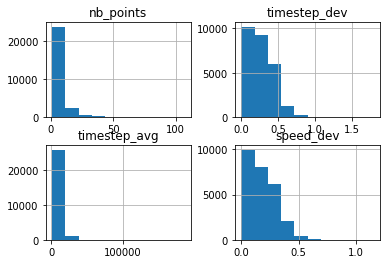

In [15]:
df.hist()

array([[<AxesSubplot:title={'center':'nb_points'}>,
        <AxesSubplot:title={'center':'timestep_dev'}>],
       [<AxesSubplot:title={'center':'timestep_avg'}>,
        <AxesSubplot:title={'center':'speed_dev'}>]], dtype=object)

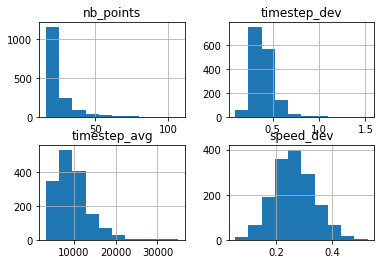

In [16]:
df[df['nb_points'] > 15].hist()

In [17]:
scores = pd.concat([
    df.groupby(['site', 'floor']).sum()['nb_points'],
    df.groupby(['site', 'floor'])[['timestep_avg', 'timestep_dev']].mean(),
    df.groupby(['site', 'floor']).size().rename('size')
], axis=1)
scores[scores['nb_points'] > 500].sort_values(
    'size', ascending=False
    # 'timestep_dev'
).head(50)

,,nb_points,timestep_avg,timestep_dev,size
site,floor,,,,
5d27075f03f801723c2e360f,F1,2027,9488.686788,0.243252,284
5cd56bdbe2acfd2d33b663c0,L3,1012,8287.753373,0.183807,272
5d27075f03f801723c2e360f,F2,1651,20023.392441,0.232707,240
5d2709b303f801723c327472,1F,1116,14296.154322,0.196116,240
5d27075f03f801723c2e360f,B1,760,11480.398596,0.147631,234
5da138b74db8ce0c98bd4774,B1,1572,6832.652591,0.319850,219
5d27075f03f801723c2e360f,F3,1470,21480.969688,0.237423,213
5da1389e4db8ce0c98bd0547,F4,873,5543.267202,0.179193,190
5cd56b6ae2acfd2d33b59ccb,B1,1527,6984.109129,0.352493,176


,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
22636,/Volumes/DD Romain/dataP3a/indoor-location-nav...,107,0.377507,9654.764151,0.342906,5da1383b4db8ce0c98bc11ab,F1,5dd3824044333f00067aa2c4
19713,/Volumes/DD Romain/dataP3a/indoor-location-nav...,74,0.350087,9949.287671,0.221722,5d2709bb03f801723c32852c,F3,5dca6b59e518c500069ebe39
17041,/Volumes/DD Romain/dataP3a/indoor-location-nav...,73,0.393298,7253.361111,0.283105,5d27075f03f801723c2e360f,F4,5da82bcd4091ff00060488cc
22040,/Volumes/DD Romain/dataP3a/indoor-location-nav...,66,0.364004,7197.907692,0.330494,5da1382d4db8ce0c98bbe92e,F4,5da536a951b5100006cbf06e
21500,/Volumes/DD Romain/dataP3a/indoor-location-nav...,66,0.358249,9936.676923,0.300244,5d2709e003f801723c32d896,F4,5dd0ad4294e4900006125b53
...,...,...,...,...,...,...,...,...
17736,/Volumes/DD Romain/dataP3a/indoor-location-nav...,16,0.292044,8070.866667,0.149799,5d27097f03f801723c320d97,F3,5dd20b5a878f3300066c7ea1
24984,/Volumes/DD Romain/dataP3a/indoor-location-nav...,16,0.168158,7751.800000,0.217598,5da958dd46f8266d0737457b,F1,5dae666eaa1d300006faabd8
20381,/Volumes/DD Romain/dataP3a/indoor-location-nav...,16,0.265916,4085.000000,0.329585,5d2709c303f801723c3299ee,8F,5daec8adaa1d300006faafe3
16573,/Volumes/DD Romain/dataP3a/indoor-location-nav...,16,0.357051,7266.933333,0.245034,5d27075f03f801723c2e360f,F2,5da7d143476f600006adccda


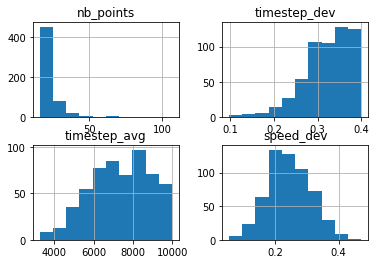

In [18]:
filtered_df = df[(df['nb_points'] > 15) & (df['timestep_dev'] < 0.4) & (df['timestep_avg'] < 10000)]
filtered_df.hist()
filtered_df

In [19]:
filtered_df.groupby(['site', 'floor']).size()

site                      floor
5cd56b5ae2acfd2d33b58549  1F        1
5cd56b64e2acfd2d33b592b3  F1        1
                          F2        1
5cd56b6ae2acfd2d33b59ccb  B1        9
                          F1        8
                                   ..
5dc8cea7659e181adb076a3f  F3        4
                          F4        4
                          F5       10
                          F6        7
                          F7        1
Length: 186, dtype: int64

In [20]:
filtered_df.groupby(['site', 'floor']).size().idxmax(), filtered_df.groupby(['site', 'floor']).size().max()

(('5d27075f03f801723c2e360f', 'F1'), 17)

,filepath,nb_points,timestep_dev,timestep_avg,speed_dev,site,floor,path_id
16301,/Volumes/DD Romain/dataP3a/indoor-location-nav...,36,0.395381,8496.828571,0.226188,5d27075f03f801723c2e360f,F1,5da6c722ab074400064323a0
16285,/Volumes/DD Romain/dataP3a/indoor-location-nav...,33,0.281143,8375.093750,0.242904,5d27075f03f801723c2e360f,F1,5da6c048aee18f0006a0ef16
16320,/Volumes/DD Romain/dataP3a/indoor-location-nav...,29,0.338981,7808.178571,0.321789,5d27075f03f801723c2e360f,F1,5da6d2a4ab07440006432428
16329,/Volumes/DD Romain/dataP3a/indoor-location-nav...,27,0.357700,7420.692308,0.301445,5d27075f03f801723c2e360f,F1,5da6dc74ab074400064324b4
16307,/Volumes/DD Romain/dataP3a/indoor-location-nav...,26,0.273246,8446.520000,0.327122,5d27075f03f801723c2e360f,F1,5da6d281ab0744000643241a
16290,/Volumes/DD Romain/dataP3a/indoor-location-nav...,25,0.296980,9052.000000,0.254403,5d27075f03f801723c2e360f,F1,5da6c0726c36940006661fe4
16352,/Volumes/DD Romain/dataP3a/indoor-location-nav...,24,0.331679,8141.782609,0.287994,5d27075f03f801723c2e360f,F1,5da6e68dab074400064325c4
16309,/Volumes/DD Romain/dataP3a/indoor-location-nav...,23,0.325573,6445.272727,0.202734,5d27075f03f801723c2e360f,F1,5da6d286ab0744000643241c
16293,/Volumes/DD Romain/dataP3a/indoor-location-nav...,23,0.271867,6516.863636,0.242319,5d27075f03f801723c2e360f,F1,5da6c084aee18f0006a0ef21
16319,/Volumes/DD Romain/dataP3a/indoor-location-nav...,22,0.354374,6829.333333,0.234983,5d27075f03f801723c2e360f,F1,5da6d2a10593fc0006699f8a


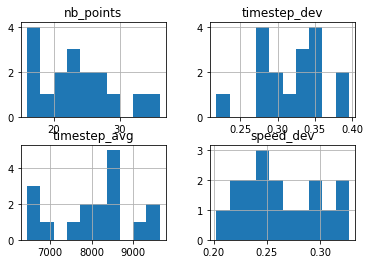

In [21]:
# site, floor = 'site1', 'F2'
site, floor = filtered_df.groupby(['site', 'floor']).size().idxmax()
final_df = filtered_df[(filtered_df['site'] == site) & (filtered_df['floor'] == floor)]
final_df.hist()
final_df

In [22]:
final_df['nb_points'].sum(), (final_df['nb_points'] * final_df['timestep_avg']).sum() // 1000 / 60

(391, 52.166666666666664)

In [24]:
if FULL:
    floor_plan_filename = f"/Volumes/DD Romain/dataP3a/indoor-location-navigation/metadata/{site}/{floor}/floor_image.png"
    floor_info_filename = f"/Volumes/DD Romain/dataP3a/indoor-location-navigation/metadata/{site}/{floor}/floor_info.json"
    print(floor_plan_filename)
else:
    floor_plan_filename = floor_data_dir + '/floor_image.png'
    floor_info_filename = floor_data_dir + '/floor_info.json'
    
with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# Building figs
figs = []
for _, row in tqdm(final_df.iterrows()):
    figs.append(visualize(
        row['filepath'], floor_plan_filename, width_meter, height_meter, 
        show=False
    ))

/Volumes/DD Romain/dataP3a/indoor-location-navigation/metadata/5d27075f03f801723c2e360f/F1/floor_image.png


0it [00:00, ?it/s]

Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.
Loading path -> done.


In [25]:
@interact(
    i=widgets.IntSlider(min=0, max=len(figs) - 1, step=1, value=5)
)
def show_path(i):
    figs[i].show()

interactive(children=(IntSlider(value=5, description='i', max=16), Output()), _dom_classes=('widget-interact',…

# Conclusion & question
## Pipeline
- We collect traces with ILC2 module **(done)**
- We convert them to a manageable format
    - 1. Convert them to .json path to be injected in the solution with the API integration **(done)**
    - 2. Convert them to .plt Geolife format (integrations/helper.py > to_plt) -> if we are willing to round all times to the closest second
- We compute stats
    - 1. Compute stats on them and store all of them in a stats file to be able to do easy filtering (just like Geolife with .plt -> stats -> filters -> loaded traces) -> can compute stats when we convert them and include them in the json -> better to build stats on json as this could be reused later (API json format) -> but OK to write them back in the json directly too **(computation done | storage left)**
    - 2. Directly leverage .plt filtering pipeline **(just implement filter functions)**
- We agregate traces
    - We need same site + floor + timestep_avg (to be used as dt unless we are willing to scale a bit -> change the speed to keep the same positions in the building)
    - Aggregate them to use the same t0 and same dt and max(tf)
    
## Data
- How should we decide on bluetooth / camera points and camera traces ? Traces are short so perhaps we can do only beginning and end as bluetooth and rest as camera points with no trace. But seems a bit hard.
- How to deal with non-periodic recording times?
- What do we want to prove with the experiments?
- Build an ICL2 object to collect initial data, build fig, stats, ... and also reconciliation function which will return the final API json data?